Here we want to estimate the fraction of events that are detected either by two or three detectors, considering design sensitivities and HLV network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from Network_SNR import Network_SNR
from Network_SNR import HLV_zerodethighP

In [7]:
# construct popoulation of binaries
Nbinaries = 3000
dLmax = 400. #Mpc

Mc = np.ones(Nbinaries)*1.2 #BNS

# dL: uniform in Euclidean space
dL0 = np.linspace(0.,dLmax,1000)
pdL = dL0**2
cdL = cumtrapz(pdL,dL0,initial=0.)
cdL/=cdL[-1]
dL = np.interp(np.random.uniform(0.,1.,Nbinaries),cdL,dL0)

# zero redshift
z = np.zeros(Nbinaries)

# isotropic inclinations
iota0 = np.linspace(0.,np.pi/2.,1000)
piota = np.sin(iota0)
ciota = cumtrapz(piota,iota0,initial=0.)
ciota/=ciota[-1]
iota = np.interp(np.random.uniform(0.,1.,Nbinaries),ciota,iota0)

# uniformly distributed polarization angles
psi0 = np.linspace(0.,np.pi,1000)
ppsi = np.ones(len(psi0))
cpsi = cumtrapz(ppsi,psi0,initial=0.)
cpsi/=cpsi[-1]
psi = np.interp(np.random.uniform(0.,1.,Nbinaries),cpsi,psi0)

# isotropic sky positions
th0 = np.linspace(0.,np.pi,1000)
pth = np.sin(th0)
cth = cumtrapz(pth,th0,initial=0.)
cth/=cth[-1]
th = np.interp(np.random.uniform(0.,1.,Nbinaries),cth,th0)

phi0 = np.linspace(0.,2*np.pi,1000)
pphi = np.ones(len(phi0))
cphi = cumtrapz(pphi,phi0,initial=0.)
cphi/=cphi[-1]
phi = np.interp(np.random.uniform(0.,1.,Nbinaries),cphi,phi0)

RAdeg = phi/np.pi*180
DECdeg = (np.pi/2-th)/np.pi*180

In [8]:
# compute SNRs in three-detector network (all three detectors are assumed to have the zerodethighP 
# PSD (the model design sensitivity for LIGO), thus they have each a 200 Mpc range. We will rescale 
# the Virgo SNR afterwards. It would be more accurate if we gave Virgo its own anticipated design
# sensitivity curve.)

SNRs = np.empty([Nbinaries,3]) # shape: (Nbinaries,Ndetectors)

# compute the network SNR for each binary (all happen at gmst=0. - this shouldn't change anything, since the
# population is isotropic)
for i in range(Nbinaries):
    SNRs[i] = Network_SNR(HLV_zerodethighP, Mc[i], dL[i], z[i], iota[i], psi[i], RAdeg[i], DECdeg[i], 0.)[1]

In [9]:
# define the Virgo range
Virgo_range = 120. # Mpc

# rescale the Virgo SNR to account for its lower range
SNRs[:,2]*=Virgo_range/200.

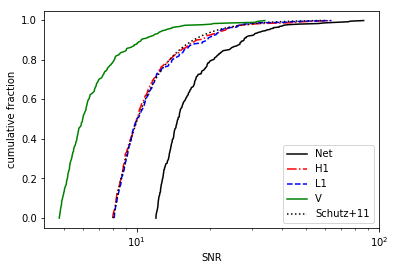

In [10]:
# compute the network SNR as (SNR_H^2 + SNR_L^2 + SNR_V^2)^(1/2)
SNR_net = np.sort((SNRs[:,0]**2 + SNRs[:,1]**2 + SNRs[:,2]**2)**0.5)

# plot the distributions of SNRs for detected binaries

## a network detection is assumed to correspond to SNR_net>12
det_network=(SNR_net>12.)
SNR_H = np.sort(SNRs[:,0])
SNR_L = np.sort(SNRs[:,1])
SNR_V = np.sort(SNRs[:,2])

# Schutz 2011 universal SNR distribution for detected inspirals, assuming SNR_limit = 8
SNRs2011 = np.linspace(8.,60.,100)
cs2011 = 1.-(SNRs2011/8.)**-3
cs2011[cs2011<0.]=0.
c = np.arange(len(SNR_net[det_network]))/len(SNR_net[det_network])

plt.plot(SNR_net[det_network],c,'-k',label='Net')
plt.plot(SNR_H[det_network],c,'-.r',label='H1')
plt.plot(SNR_L[det_network],c,'--b',label='L1')
plt.plot(SNR_V[det_network],c,'-g',label='V')
plt.plot(SNRs2011,cs2011,':k',label='Schutz+11')
plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('cumulative fraction')
plt.legend()


In [11]:
# count 3-det and 2-det detections
det_single = (SNRs>4.)
det_network = ((SNRs[:,0]**2 + SNRs[:,1]**2 + SNRs[:,2]**2)**0.5>12.)

Ndet = np.sum(det_single,axis=1)

N3det = len(Ndet[(Ndet==3.) & det_network])
N2det = len(Ndet[(Ndet==2.) & det_network])
NH1det = len(Ndet[det_single[:,0] & det_network])
NL1det = len(Ndet[det_single[:,1] & det_network])
NVdet = len(Ndet[det_single[:,2] & det_network])

print("Fraction of binaries within {0:.1f} Mpc detected by all three detectors: {1:.1f}%".format(dLmax,N3det/Nbinaries*100))
print("Fraction detected by only two detectors: {0:.1f}%".format(N2det/Nbinaries*100))
print("Total: {0:.3g}%".format((N3det+N2det)/Nbinaries*100))
print("Virgo contributes to {0:.1f}% of the detections".format(NVdet/(N3det+N2det)*100))
print("Hanford contributes to {0:.1f}% of the detections".format(NH1det/(N3det+N2det)*100))
print("Livingston contributes to {0:.1f}% of the detections".format(NL1det/(N3det+N2det)*100))

# print the corresponding detection rates
R0 = np.array([1540.,320.,4800.]) # Gpc-3 yr-1

V = 4*np.pi/3.*(dLmax/1000.)**3 # total simulated volume in Gpc3

R = (N3det+N2det)/Nbinaries*R0*V # total detection rate for three detectors with 100% duty cycle

dc = 0.7 # single-detector duty cycle

dc3 = dc**3 # three-detector duty cycle
dc2 = dc**2*(1.-dc) # two-detector duty cycle
dcn = (dc3 + dc2) # network duty cycle

print("Total detection rate: {0:.0f} ({1:.0f},{2:.0f}) yr-1 x duty-cycle (assuming a {3:.0f} ({4:.0f},{5:.0f}) Gpc-3 yr-1 local rate)".format(R[0],R[1],R[2],R0[0],R0[1],R0[2]))

print("Assuming a {0:.2f} duty cycle per detector, we have:".format(dc))
print("Only two detectors online: {0:.1f} percent of the time".format(dc2*100))
print("All three detectors online: {0:.1f} percent of the time".format(dc3*100))
print("At least two detectors online: {0:.1f} percent of the time".format(dcn*100))


Fraction of binaries within 400.0 Mpc detected by all three detectors: 6.3%
Fraction detected by only two detectors: 4.9%
Total: 11.2%
Virgo contributes to 57.9% of the detections
Hanford contributes to 99.1% of the detections
Livingston contributes to 99.4% of the detections
Total detection rate: 46 (10,144) yr-1 x duty-cycle (assuming a 1540 (320,4800) Gpc-3 yr-1 local rate)
Assuming a 0.70 duty cycle per detector, we have:
Only two detectors online: 14.7 percent of the time
All three detectors online: 34.3 percent of the time
At least two detectors online: 49.0 percent of the time
